# Importance of recent train seasons
We will evaluate the proposed AdaBoost model over 14 test seasons from 2014NH to 2020SH, where the model will be trained over subsets of training data containing only 1 to 5 recent seasons.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = "GIAG010101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',   # virus passage category
                 'serumPassCat'   # serum passage category
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

recentTrainSeasons_all = [1, 2, 3, 4, 5, 'all']   # number of recent seasons for training

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig8_recentTrainSeasons/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn    = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
results_fn = path_result + "SuppFig8_recentTrainSeasons.csv"   # to save performance scores for test dataset
fig_fn     = path_result + 'SuppFig8_recentTrainSeasons.svg'   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Function to compute performance of model for a given season
- Split the data into training and validation datasets
- Prepare encoded inputs (genetic difference and metadata features)
- Train and validate the model
- Compute predictive performance

> **Parameters**
> - season (str): identifier for the Northern of Southern Hemisphere season such as "2015NH"

> **Returns**
> - (numpy array): actual NHTs for the given season
> - (numpy array): predicted NHTs for the given season

In [9]:
def train_test_season(season, recent_train_seasons):
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.recentTrainSeasons_seasonal_trainTestSplit(data[['virus', 'serum', 'virusDate', 'serumDate']],
                                                                               test_season=season,
                                                                               train_seasons=recent_train_seasons)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                          index=data_test.index,
                          columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    '''
    Target (NHTs)
    '''
    y_train = data_train.nht.values
    y_test  = data_test.nht.values


    del X_train_meta, X_test_meta, data_train, data_test
    gc.collect()
        
    
    '''
    Training and testing
    '''
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    y_train,
                    X_test = X_test)
    
    
    '''
    Test Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'recent_train_seasons', 'season']
    col_values = [mut_mat, model_name, metadata, str(recent_train_seasons), season]
    utilities.compute_scores(y_test, results['pred_test'], results_fn, col=cols, col_val=col_values)
    
    
    return season, y_test, results['pred_test']

## Performance of the model
- For each number of recent train seasons
    - For each test season from 2014NH to 2020SH
        - Split the data into training and test datasets
        - Prepare encoded inputs (genetic difference and metadata features)
        - Train and evaluate the model
        - Compute predictive performance
        - Save the predictions
    - Compute average predictive performance

In [11]:
'''
Recent train season
'''
for recent_train_seasons in recentTrainSeasons_all:
    print("No. of recent train seasons: ", recent_train_seasons)
    
    # train test for each test season in parallel
    result = Parallel(n_jobs=-1, verbose=1)(delayed(train_test_season)(test_season, recent_train_seasons) for test_season in Test_Seasons)

    # get results
    seasons, actual_all, predict_all = zip(*result)

    '''
    Micro-average over seasons
    '''
    actual  = np.concatenate(actual_all)
    predict = np.concatenate(predict_all)

    # Test scores
    cols       = ['mut_mat', 'model', 'metadata', 'recent_train_seasons', 'season']
    col_values = [mut_mat, model_name, metadata, str(recent_train_seasons), 'Average']
    utilities.compute_scores(actual, predict, results_fn, col=cols, col_val=col_values)
    

    ####################################
    # loop over missed_train_Seasons end
    ####################################

No. of recent train seasons:  1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-09 17:12:27.548304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 17:12:27.869031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 17:12:28.390734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

No. of recent train seasons:  2


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:   33.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   41.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


No. of recent train seasons:  3


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  1.3min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


No. of recent train seasons:  4


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  2.8min remaining:   27.9s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


No. of recent train seasons:  5
Time for training: 1.6414127349853516
Time for training: 5.097602605819702
Time for training: 11.431537389755249
Time for training: 56.704602003097534
Time for training: 7.923105239868164
Time for training: 5.689915895462036
Time for training: 16.205386638641357
Time for training: 56.10739493370056
Time for training: 1.3576254844665527
Time for training: 22.8556809425354
Time for training: 63.48865079879761
Time for training: 8.823132276535034
Time for training: 19.51027274131775
Time for training: 76.31313228607178
Time for training: 6.5689921379089355
Time for training: 20.48247218132019
Time for training: 80.82113742828369
Time for training: 4.958163261413574
Time for training: 19.014780044555664
Time for training: 135.10186052322388


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  4.5min remaining:   44.7s


Time for training: 6.4405341148376465
Time for training: 12.352993726730347
Time for training: 138.94691014289856
Time for training: 2.015331745147705
Time for training: 18.98926830291748
Time for training: 152.71525764465332
Time for training: 3.205144166946411
Time for training: 9.057804822921753
Time for training: 157.33922290802002
Time for training: 1.211958408355713
Time for training: 19.38110327720642
Time for training: 168.64610934257507


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


No. of recent train seasons:  all
Time for training: 4.840788125991821
Time for training: 83.1132299900055
Time for training: 78.87036371231079
Time for training: 292.1709985733032
Time for training: 1.4597887992858887
Time for training: 26.04941463470459
Time for training: 33.01992654800415
Time for training: 81.44860458374023
Time for training: 464.96219205856323
Time for training: 2.033846855163574
Time for training: 75.82815790176392
Time for training: 92.36178159713745
Time for training: 736.8944439888
Time for training: 1.6760876178741455
Time for training: 23.625807762145996
Time for training: 50.984036684036255
Time for training: 88.73422122001648
Time for training: 994.7733643054962
Time for training: 6.104187250137329
Time for training: 5.136704683303833
Time for training: 60.36126947402954
Time for training: 104.86640858650208
Time for training: 1135.936121225357
Time for training: 4.8077778816223145
Time for training: 36.33672618865967
Time for training: 56.1363468170166
Ti

[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 46.2min remaining:  7.7min


Time for training: 8.864545583724976
Time for training: 32.00957226753235
Time for training: 249.57732844352722
Time for training: 2660.7360785007477
Time for training: 1.3632218837738037
Time for training: 1.4735798835754395
Time for training: 3.948514223098755
Time for training: 41.13131070137024
Time for training: 274.3105070590973
Time for training: 3184.0419986248016


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 64.7min finished


Time for training: 2.6583516597747803
Time for training: 6.2402732372283936
Time for training: 39.17485165596008
Time for training: 299.82994556427
Time for training: 3738.694814682007


## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores and prepare data for plots

In [6]:
scores = pd.read_csv(results_fn)
# convert to int
scores['recent_train_seasons'] = [int(n) if n!='all' else n for n in scores.recent_train_seasons]
scores = scores[scores.recent_train_seasons.isin([1, 2, 3, 4, 5, 'all'])].copy()

## Plot MAE vs. number of recent seasons for training

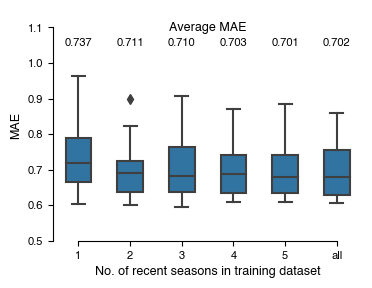

In [11]:
fig, ax = plt.subplots(figsize=(4,3))

plot = sns.boxplot(x='recent_train_seasons', y='MAE', data=scores[scores.season!='Average'],
                   width=0.5,
                   color="C0",
                   ax=ax)

# annotate
for (xtick, label) in zip(plot.get_xticks(), scores[scores.season=='Average'].MAE):
    ax.text(xtick,
            1.05,
            f"{label:.3f}",
            horizontalalignment='center',
            fontsize=8,
            rotation=0)

ax.text(2.5, 1.09, "Average MAE", fontsize=9, horizontalalignment='center')

# configurations for figure
ax.set_xlabel('No. of recent seasons in training dataset', fontsize=9)
ax.set_ylabel('MAE', fontsize=9)
ax.set_ylim(bottom=0.5, top=1.15)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')